<a href="https://colab.research.google.com/github/ariG23498/NeuralStyleTransfer/blob/master/Content_and_Style_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
import cv2
from tqdm import tqdm

In [2]:
print('tf Version: {}'.format(tf.__version__))
print('Executing eagerly: {}'.format(tf.executing_eagerly()))

tf Version: 2.3.0
Executing eagerly: True


# Dataset

In [3]:
# Gather dataset
anchor_image_path = tf.keras.utils.get_file(
    "paris.jpg", "https://i.imgur.com/F28w3Ac.jpg"
    )
style_image_path = tf.keras.utils.get_file(
    "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg"
    )

942080/935806 [==============================] - 1s 1us/step


In [4]:
def prepare_image(image_path):
  image_pixels = plt.imread(image_path)
  image_pixels = cv2.resize(image_pixels, (224, 224))
  image_pixels = image_pixels/255.
  image = np.array(image_pixels, dtype=np.float32)
  print(image.shape)
  return image

In [5]:
anchor = prepare_image(anchor_image_path)
style = prepare_image(style_image_path)

(224, 224, 3)
(224, 224, 3)


In [6]:
print(anchor.dtype)
print(style.dtype)

float32
float32


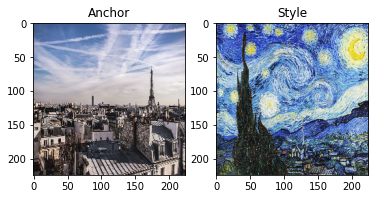

In [7]:
plt.subplot(1,2,1)
plt.imshow(anchor)
plt.title('Anchor')
plt.subplot(1,2,2)
plt.imshow(style)
plt.title('Style')
plt.show()

# Pretrained VGG16

In [8]:
model = tf.keras.applications.VGG16()
model.summary()

553467904/553467096 [==============================] - 13s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [9]:
for layer in model.layers:
  layer.trainable = False

In [10]:
for layer in model.layers:
  print('{} trainable: {}'.format(layer.name, layer.trainable))

input_1 trainable: False
block1_conv1 trainable: False
block1_conv2 trainable: False
block1_pool trainable: False
block2_conv1 trainable: False
block2_conv2 trainable: False
block2_pool trainable: False
block3_conv1 trainable: False
block3_conv2 trainable: False
block3_conv3 trainable: False
block3_pool trainable: False
block4_conv1 trainable: False
block4_conv2 trainable: False
block4_conv3 trainable: False
block4_pool trainable: False
block5_conv1 trainable: False
block5_conv2 trainable: False
block5_conv3 trainable: False
block5_pool trainable: False
flatten trainable: False
fc1 trainable: False
fc2 trainable: False
predictions trainable: False


# Layers of the model

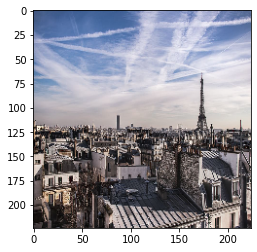

In [11]:
# the layers that I want to tap
layers = [
          'block5_pool',
          'block4_pool',
          'block3_pool',
          'block2_pool',
          'block1_pool'
]
# The input of choice
X = tf.constant(tf.expand_dims(anchor,0))
plt.imshow(X[0])
plt.show()

In [12]:
# the models created
models = list()
# images created
white_images = list()
# outputs created
output_images = list()
# loss created
losses = list()

for layer in layers:
  m = tf.keras.Model(
      inputs=model.input,
      outputs=model.get_layer(layer).output
      )
  models.append(m)

  white_images.append(
      # tf.Variable(tf.expand_dims(anchor,0))
      tf.Variable(tf.ones(shape=(1,224,224,3)))
      # tf.Variable(tf.random.normal(shape=(1,224,224,3)))
      )
  
  losses.append(
      list()
      )
  
  output_images.append(
      m(X)
  )

In [18]:
print(models[0](X).shape, models[0](white_images[0]).shape)
diff = (models[0](X) - models[0](white_images[0]))**2
print(diff.shape)
s = tf.reduce_sum(diff)
print(s)

(1, 7, 7, 512) (1, 7, 7, 512)
(1, 7, 7, 512)
tf.Tensor(2218.579, shape=(), dtype=float32)


In [19]:
def train_step(anchor, white, slice_model, loss_history):
  with tf.GradientTape() as tape:
    output_white_image = slice_model(white)
    diff = 0.5 * (anchor - output_white_image)**2
    loss = tf.reduce_sum(diff)

  loss_history.append(loss.numpy().mean())
  grads = tape.gradient(loss, [white])
  optimizer.apply_gradients(
      zip(grads, [white])
      )

# Iterate and watch

In [23]:
optimizer = tf.keras.optimizers.Adam()
for idx,layer in enumerate(layers):
  print("For {} layer. Name {}".format(idx, layer))
  for i in tqdm(range(100)):
    train_step(output_images[idx], white_images[idx], models[idx], losses[idx])

  1%|          | 1/100 [00:00<00:11,  8.58it/s]

For 0 layer. Name block5_pool


  2%|▏         | 2/100 [00:00<00:06, 15.56it/s]

For 1 layer. Name block4_pool


  3%|▎         | 3/100 [00:00<00:04, 22.26it/s]

For 2 layer. Name block3_pool


  4%|▍         | 4/100 [00:00<00:02, 34.76it/s]

For 3 layer. Name block2_pool


  7%|▋         | 7/100 [00:00<00:01, 60.97it/s]

For 4 layer. Name block1_pool


100%|██████████| 100/100 [00:01<00:00, 61.56it/s]


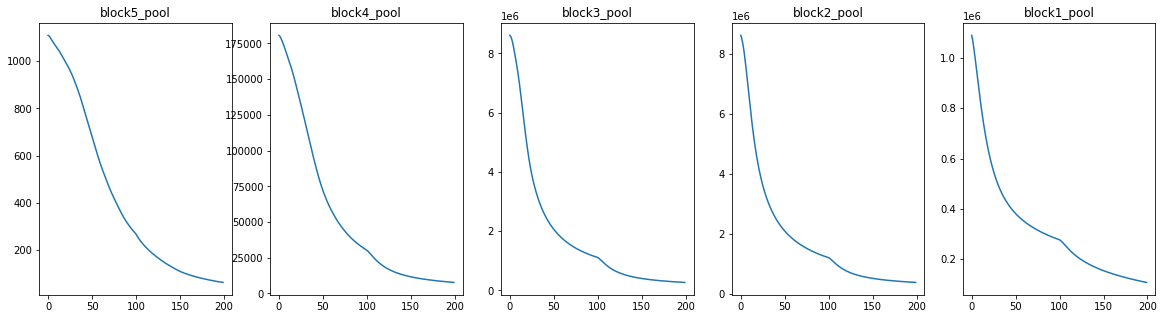

In [24]:
plt.figure(figsize=(20,5))
for idx,loss in enumerate(losses):
  plt.subplot(1,5,idx+1)
  plt.plot(loss) 
  plt.title(layers[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


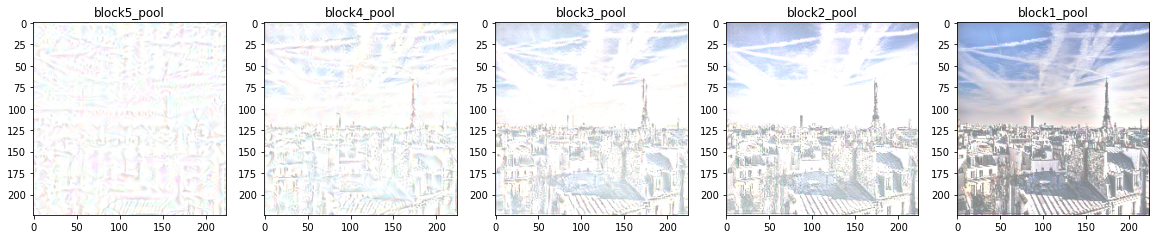

In [25]:
plt.figure(figsize=(20,5))
for idx,image in enumerate(white_images):
  plt.subplot(1,5,idx+1)
  plt.imshow(image[0])
  plt.title(layers[idx])

## Style

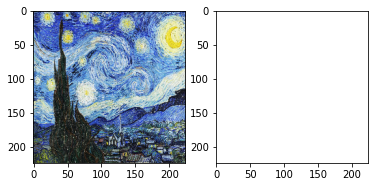

In [49]:
X = tf.expand_dims(style,0)
white_image = tf.Variable(tf.ones(shape=(1,224,224,3)))
plt.subplot(1,2,1)
plt.imshow(X[0])
plt.subplot(1,2,2)
plt.imshow(white_image[0])
plt.show()

In [50]:
# Gram matrix
def gram_matrix(input_tensor):
  result = tf.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  # input_shape = tf.shape(input_tensor)
  # num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result

In [54]:
def train_step(anchor, white, models):
  with tf.GradientTape() as tape:
    loss = 0
    for idx,model in enumerate(models):
      output_white_image = model(white)
      output_anchor_image = model(anchor)

      temp_shape = output_white_image.shape

      gram_white = gram_matrix(output_white_image)
      gram_anchor = gram_matrix(output_anchor_image)
      diff = (gram_anchor - gram_white)**2

      loss += tf.reduce_sum(diff)
    loss *= 0.25/(temp_shape[1]**2 * temp_shape[3]**2)
  # loss_history.append(loss.numpy().mean())
  grads = tape.gradient(loss, [white])
  optimizer.apply_gradients(
      zip(grads, [white])
      )

In [57]:
optimizer = tf.keras.optimizers.Adam()
for i in tqdm(range(500)):
  train_step(X, white_image, models)

100%|██████████| 500/500 [03:45<00:00,  2.22it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


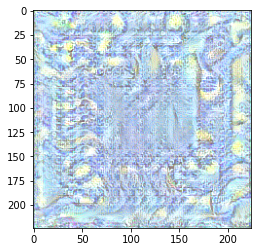

In [58]:
plt.imshow(white_image[0])